## Importing important libraries

In [1]:
import pandas as pd
import numpy as np
import cv2
import re
import gc
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from matplotlib.image import imread
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [3]:
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras as K
from keras import applications

## Defining the configuration files and loading the data

In [4]:
# Use only 1000 images when True
SUBMIT=True
DEBUG = False

# Defining which part of the model is being used
IMG = True
EXTRA_LAYERS = False
TEXT = True
PHASH = False
SIM_PHASH = False

#Defining the path to the images and properties
PATH = '../input/shopee-product-matching/'
IMG_SIZE = 456 # avg img size = 444, EfficientNetB5 = 456
BATCH = 5000
IMG_SIM_THRESHOLD = 0.25
TEXT_SIM_THRESHOLD = 0.45
PHASH_SIM_THRESHOLD = 6

## Loading the data

In [5]:

test = pd.read_csv(PATH + 'test.csv')
train = pd.read_csv(PATH + 'train.csv')

In [6]:
if DEBUG:
    train = train.sample(n = 1000).reset_index(drop = True)

if SUBMIT: 
    img_path = PATH +"/test_images/"
    train = test 
else:
    img_path = PATH +"/train_images/"
    # convert label_group to target
    tmp = train.groupby('label_group').posting_id.agg('unique').to_dict()
    train['target'] = train.label_group.map(tmp)
    train

## Creating Data Generator and performing image pre-processing

In [7]:
# images pre-processing

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, df, img_size=IMG_SIZE, batch_size=32, path=''): 
        self.df = df
        self.img_size = img_size
        self.batch_size = batch_size
        self.path = path
        self.indexes = np.arange( len(self.df) )
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        ct = len(self.df) // self.batch_size
        ct += int(( (len(self.df)) % self.batch_size)!=0)
        return ct

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X = self.__data_generation(indexes)
        return X
            
    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' 
        X = np.zeros((len(indexes),self.img_size,self.img_size,3),dtype='float32')
        df = self.df.iloc[indexes]
        for i,(index,row) in enumerate(df.iterrows()):
            img = cv2.imread(self.path + row['image'])
            X[i,] = cv2.resize(img,(self.img_size,self.img_size))
        return X

## Obtaining image embeddings using Efficient Net

### EfficientNet

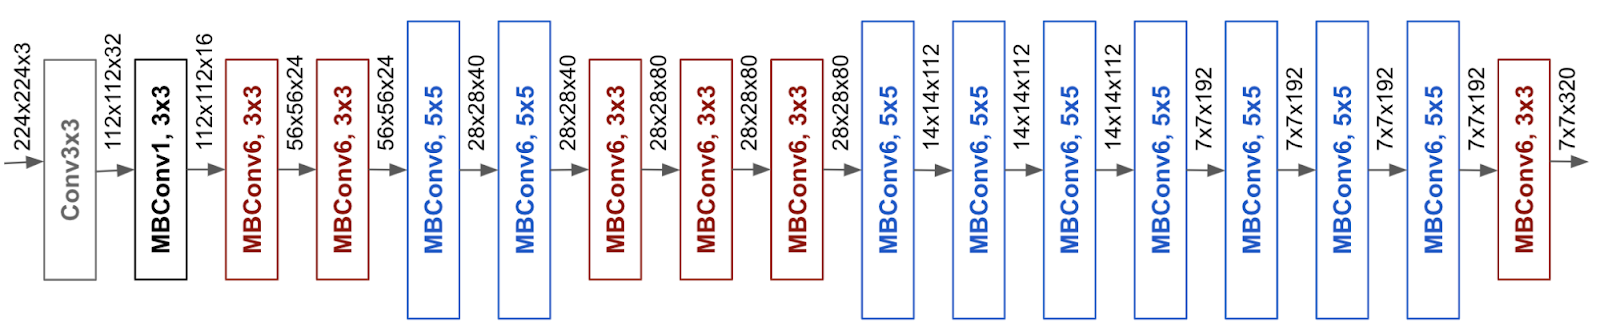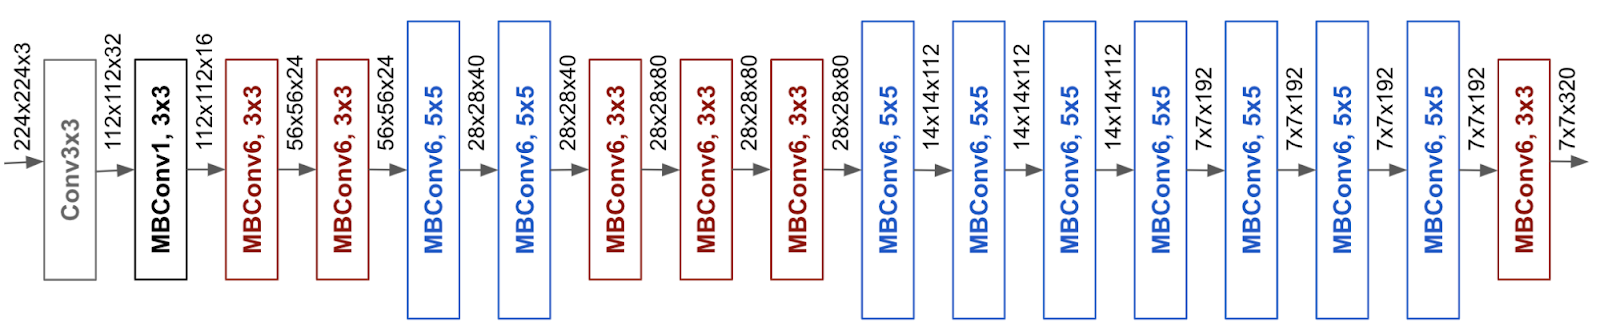

EfficientNet is a convolutional neural network architecture and scaling method that uniformly scales all dimensions of depth/width/resolution using a compound coefficient. Unlike conventional practice that arbitrary scales these factors, the EfficientNet scaling method uniformly scales network width, depth, and resolution with a set of fixed scaling coefficients. 

The compound scaling method is justified by the intuition that if the input image is bigger, then the network needs more layers to increase the receptive field and more channels to capture more fine-grained patterns on the bigger image.


### Using pre-trained EfficientNetB5 model

In [8]:
if IMG:
    
    WGT = "../input/tfkerasefficientnetimagenetnotop/efficientnetb5_notop.h5"
    eff_net = K.applications.EfficientNetB5(weights=WGT, input_shape=None, include_top=False, pooling="avg", drop_connect_rate=0.2)
    
    if EXTRA_LAYERS == False: model = eff_net

In [9]:
# apply images to pre-trained model (EfficientNet)
if IMG:
    
    #chunk = BATCH 
    #cls = len(train) // chunk 
    #cls += int (len(train) % chunk != 0)
    #image_embedding = []
    #for i in tqdm(range(cls)) :

    #    a = i * chunk 
    #    b = (i+1) * chunk 
    #    b = min(b,len(train))
    #    data = DataGenerator(train.iloc[a:b], path=img_path)
    #    emb = model.predict(data, use_multiprocessing=True, workers=8)
    #    image_embedding.append(emb)

    data = DataGenerator(train, path=img_path)
    image_embedding = model.predict(data, use_multiprocessing=True, workers=8)
    
    del(model)
    gc.collect()

## Applying Nearest Neighbours technique 

In [10]:
#IMG_SIM_THRESHOLD = 0.15
# get images prediction from nearest image embeddings

if IMG:
    
    nn = 50
    # prevent bug while submiting to kaggle
    if len(test)==3: nn = 3
    knn = NearestNeighbors(n_neighbors=3, metric ="cosine")
    knn.fit(image_embedding)
    
    chunk = BATCH
    cl = len(train) // chunk 
    cl += int((len(train) % chunk) !=0)
    pred_img = []
    for i in tqdm(range(cl)) :

        a = i * chunk
        b = (i+1) * chunk
        b = min(len(train),b)
        distances,indices = knn.kneighbors(image_embedding[a:b,])
        for j in range(b-a):
            distance = distances[j,:]
            ind = np.where(distance < IMG_SIM_THRESHOLD)[0]
            IND = indices[j,ind]
            pred_img.append(train.iloc[IND].posting_id.values)

    train["pred_img"] = pred_img

100%|██████████| 1/1 [00:00<00:00, 173.21it/s]


## Performing text predictions

In [17]:
# text pre-processing

def letters_only(text):
    return re.sub("[^a-zA-Z]", " ", text)

def lowercase_only(text):
    return text.lower()

def remove_patterns(text):
    '''
    Some titles contain " x " as separators.
    Example: train_3369186413
    '''
    patterns = {' x ': ' ',
               ' a ': ' '}
    for k, v in patterns.items():
        text = text.replace(k,v)
    return text

def replace_multispace_by_space(text):
    return re.sub('\s+',' ',text)

## There are some Indonesian words so we will
## convert those into English

#cm_map adjusted - Source of original cm_map : https://www.kaggle.com/c/shopee-product-matching/discussion/228358
cm_map = {"wanita": "woman", 
          "anak": "child", 
          "bayi": "baby",
          "tas": "bag", 
          "masker": "face mask", 
          "pria": "men",
          "murah": "cheap",
          "tangan": "hand", 
          "alat": "tool", 
          "motif": "motive", 
          "warna": "color", 
          "bahan": "material", 
          "celana": "pants", 
          "baju": "clothes", 
          "kaos": "t-shirt", 
          "sepatu": "shoes", 
          "rambut": "hair", 
          "mainan": "toy", 
          "sarung": "holster", 
          "polos": "plain", 
          "rak": "rack", 
          "botol": "bottle", 
          "sabun": "soap", 
          "kain": "fabric", 
          "panjang": "long", 
          "kabel": "cable", 
          "buku": "book", 
          "plastik": "plastic", 
          "mobil": "car", 
          "hitam": "black", 
          "karakter": "character", 
          "putih": "white", 
          "dompet": "purse", 
          "kaki": "feet", 
          "pembersih": "cleaners", 
          "lipat": "folding", 
          "silikon": "silicone", 
          "minyak": "oil", 
          "isi": "contents", 
          "paket": "package", 
          "susu": "milk", 
          "gamis": "robe", 
          "mandi": "bath", 
          "madu": "honey", 
          "kulit": "skin", 
          "serbaguna": "multipurpose", 
          "bisa": "can", 
          "kacamata": "spectacles", 
          "pendek": "short", 
          "tali": "rope", 
          "selempang": "sash",
          "topi": "hat", 
          "obat": "drug", 
          "gantungan": "hanger", 
          "tahun": "year", 
          "jilbab": "hijab", 
          "dapur": "kitchen", 
          "dinding": "wall",
          "kuas": "brush",
          "perempuan": "woman",
          "katun": "cotton", 
          "sepeda": "bike", 
          "lucu": "funny", 
          "lengan": "arm", 
          "kaca": "glass", 
          "garansi": "warranty", 
          "bunga": "flower", 
          "handuk": "towel", 
          "dewasa": "adult", 
          "elektrik": "electric", 
          "timbangan": "balance", 
          "besar": "big", 
          "bahan": "ingredient", 
          "ransel": "backpack", 
          "kertas": "paper",
          "lampu" : "light",
          "sepatu": "shoes",
          "tempat": "place"}

def translate_ind_to_eng(text):
    res = " ".join(cm_map.get(w, w) for w in text.split())    
    return res

In [18]:
# text clean up
# removed .apply(letters_only)
if TEXT:
    X = (train['title'].apply(lowercase_only)
                       .apply(remove_patterns)
                       .apply(replace_multispace_by_space)
                       .apply(translate_ind_to_eng))

### Using TF-IDF vectorizer

In [19]:
#TEXT_SIM_THRESHOLD = 0.45
# get images prediction from nearest image embeddings

if TEXT:
    #vectorizer = CountVectorizer()
    vectorizer =  TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')
    X_mat = vectorizer.fit_transform(X)

    nn = 50
    # prevent bug while submitting to kaggle
    if len(test)==3: nn = 3
    knn = NearestNeighbors(n_neighbors=3, metric ="cosine")
    knn.fit(X_mat)

    # get images prediction from nearest image embeddings
    chunk = BATCH
    cl = len(train) // chunk 
    cl += int((len(train) % chunk) !=0)
    pred_text = []
    for i in tqdm(range(cl)) :

        a = i * chunk
        b = (i+1) * chunk
        b = min(len(train),b)
        distances,indices = knn.kneighbors(X_mat[a:b,])
        for j in range(b-a):
            distance = distances[j,:]
            ind = np.where(distance < TEXT_SIM_THRESHOLD)[0]
            IND = indices[j,ind]
            pred_text.append(train.iloc[IND].posting_id.values)

    train["pred_text"] = pred_text

100%|██████████| 1/1 [00:00<00:00, 257.27it/s]


## Performing pHash predictions

Perceptual hash (pHash), which acts as an image fingerprint. This mathematical algorithm analyzes an image's content and represents it using a 64-bit number fingerprint. Two images’ pHash values are "close" to one another if the images’ content features are similar. By comparing two image fingerprints, you can tell if they are similar.

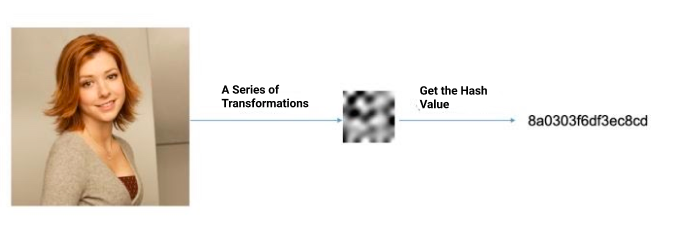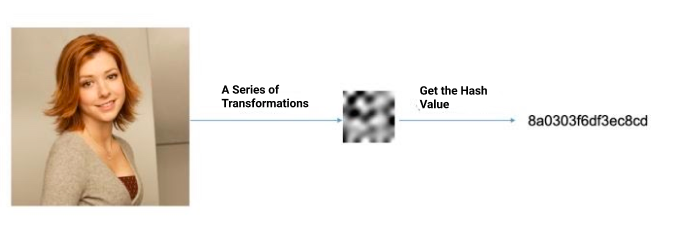

In [20]:
# group identical phash
if PHASH:
    tmp = train.groupby('image_phash').posting_id.agg('unique').to_dict()
    train['pred_phash'] = train.image_phash.map(tmp)

In [21]:
# group similar phash
if SIM_PHASH:
    def hamming_distance(hash1, hash2):  
        return sum([c1 != c2 for c1, c2 in zip(hash1, hash2)])

    # very long to run and there's no gain compared to pred_img
    
    # check all phash with hamming distance < 6
    train['pred_phash'] = np.nan
    for i in tqdm(range(train.shape[0])):
        train['dist'] = train['image_phash'].apply(lambda x: hamming_distance(x,train['image_phash'].iloc[i]))
        train['pred_phash'].iloc[i] =  [x for x in train['posting_id'].loc[train['dist'] < PHASH_SIM_THRESHOLD]]

## Combining text prediction and pHash

In [22]:
def combine_predictions(row):
    if PHASH and TEXT and IMG:
        y = np.concatenate([row['pred_phash'], row['pred_text'], row['pred_img']])
    if TEXT and IMG:    
        y = np.concatenate([row['pred_text'], row['pred_img']])
    if PHASH and TEXT:    
        y = np.concatenate([row['pred_phash'], row['pred_text']])
    if PHASH and IMG:    
        y = np.concatenate([row['pred_phash'], row['pred_img']])
    return list(np.unique(y))
                        
train['pred'] = train.apply(lambda x: combine_predictions(x),axis=1)

In [23]:
if SUBMIT == False: 
    print("f1 score for combined pred :", round(train.apply(getMetric('pred'),axis=1).mean(), 3))

## Here submission refers to the predicting the test data using the trained model


In [24]:
submission = pd.DataFrame()

def combine_pred(row):
    if PHASH and TEXT and IMG:
        y = np.concatenate([row['pred_phash'], row['pred_text'], row['pred_img']])
    if TEXT and IMG:
        y = np.concatenate([row['pred_text'], row['pred_img']]) 
    if PHASH and TEXT:
        y = np.concatenate([row['pred_phash'], row['pred_text']])    
    if PHASH and IMG:    
        y = np.concatenate([row['pred_phash'], row['pred_img']])
    return " ".join(np.unique(y)) 

submission['posting_id'] = train['posting_id']
submission['matches'] = train.apply(lambda x: combine_pred(x),axis=1)

submission.to_csv("submission.csv",index = False)
submission.head()

,posting_id,matches
0,test_2255846744,test_2255846744 test_4015706929
1,test_3588702337,test_3588702337
2,test_4015706929,test_2255846744 test_4015706929


### posting_id: the ID code for the posting. 
### matches: Space delimited list of all posting IDs that match this posting. Posts always self-match. 